#  Introduction

Collaborative filtering is a powerful technique in recommendation systems, aiming to predict a user's preferences based on the behavior and preferences of similar users. One popular approach within collaborative filtering is the use of embeddings, which transform user and item indices into dense vectors that capture latent features in a shared space. In this context, the provided code snippet showcases the construction of a collaborative filtering model using embeddings for user and movie interactions. The essence of this model lies in its ability to discern the latent relationships between users and movies through a dot product operation on their respective embeddings. This introduction will delve into the key components of the code, shedding light on how the dot product serves as a crucial mechanism for predicting movie ratings and how the model is trained to optimize these predictions. Understanding the intricacies of collaborative filtering models and the role of the dot product is fundamental to grasping how such systems effectively recommend items to users based on their historical preferences and behaviors.

In [20]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from datetime import datetime

import keras
from pylab import rcParams

from keras import backend as K
from keras.layers import Dense, Concatenate
from keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from keras.layers import Input, Embedding, Flatten, Dot
from keras.layers import Dot
from tensorflow.keras.layers import dot
from keras.models import Model

from keras.layers import Dropout, Flatten,Activation,Input,Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn
from IPython.display import SVG

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, ParameterGrid
from keras.wrappers.scikit_learn import KerasRegressor
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [2]:
ratingsDf = pd.read_csv('~/Desktop/Work/movielens_recommendation/ratings.csv')

## EDA

In [3]:
ratingsDf.drop_duplicates(inplace=True)

print('we have',ratingsDf.shape[0], 'ratings')
print('the number of unique users we have is:', len(ratingsDf.userId.unique()))
print('the number of unique movies we have is:', len(ratingsDf.movieId.unique()))
print('The max rating is: %d'%ratingsDf.rating.max(),"the min rating is: %d"%ratingsDf.rating.min())

we have 1000209 ratings
the number of unique users we have is: 6040
the number of unique movies we have is: 3706
The max rating is: 5 the min rating is: 1


In [7]:
ratingsDf.userId = ratingsDf.userId.astype('category').cat.codes.values
ratingsDf.movieId = ratingsDf.movieId.astype('category').cat.codes.values

In [8]:
users = ratingsDf.userId.unique()
movies = ratingsDf.movieId.unique()

user_id_to_idx = {user_id: idx for idx, user_id in enumerate(users)}
movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(movies)}

ratingsDf['userId'] = ratingsDf['userId'].apply(lambda x: user_id_to_idx[x])
ratingsDf['movieId'] = ratingsDf['movieId'].apply(lambda x: movie_id_to_idx[x])

split = np.random.rand(len(ratingsDf)) < 0.8
train = ratingsDf[split]
valid = ratingsDf[~split]

In [12]:
print(valid.shape)
print(train.shape)

(199439, 4)
(800770, 4)


In [13]:
# Get the number of unique users and movies
n_users = len(ratingsDf['userId'].unique())
n_movies = len(ratingsDf['movieId'].unique())

results_list = []

def create_model(n_users, n_movies, n_latent_factors, lossFcn, optimizer, batch_size, epochs):
    """
    params:
    n_users (Integer): The number of users in a matrix
    n_movies (Integer): The number of movies in a matrix
    n_latent_factors (Integer): hyperparameter tuning
    lossFcn (String): loss function
    optimizer (String): optimizer
    batch_size (Integer): batch size
    epochs (Integer): epochs
    """
    
    user_input = Input(shape=(1,), name='user_input', dtype='int64')
    user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)
    user_vec = Flatten(name='FlattenUsers')(user_embedding)

    movie_input = Input(shape=(1,), name='movie_input', dtype='int64')
    movie_embedding = Embedding(n_movies, n_latent_factors, name='movie_embedding')(movie_input)
    movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

    sim = dot([user_vec, movie_vec], name='dot_product', axes=1)

    model = Model([user_input, movie_input], sim)
    model.compile(optimizer=optimizer, loss=lossFcn)

    result = model.fit([train.userId, train.movieId], train.rating, batch_size=batch_size,
                       epochs=epochs, validation_data=([valid.userId, valid.movieId], valid.rating),
                       verbose=0)
    
        
    return {'n_latent_factors': n_latent_factors,
            'train_loss': result.history['loss'][-1],
            'val_loss': result.history['val_loss'][-1]}

# Define hyperparameter values
latent_factor_values = [4, 5, 6, 7, 8, 16, 24, 32, 40, 48]
loss_functionsList = 'mean_squared_error' 
optimizerList = 'adam'
batch_size = 128
epochs=10

for params in latent_factor_values:
    results = create_model(n_users, n_movies, params, loss_functionsList, optimizerList, batch_size, epochs)
    results_list.append(results)

In [15]:
# Print the results
for result in results_list:
    print(f"n_latent_factors: {result['n_latent_factors']}, Train Loss: {result['train_loss']}, Val Loss: {result['val_loss']}")

n_latent_factors: 4, Train Loss: 0.8343020677566528, Val Loss: 0.8341817259788513
n_latent_factors: 5, Train Loss: 0.8255375027656555, Val Loss: 0.8240563869476318
n_latent_factors: 6, Train Loss: 0.816630482673645, Val Loss: 0.8162664175033569
n_latent_factors: 7, Train Loss: 0.7847368717193604, Val Loss: 0.7935526371002197
n_latent_factors: 8, Train Loss: 0.78956139087677, Val Loss: 0.8003777265548706
n_latent_factors: 16, Train Loss: 0.6965188980102539, Val Loss: 0.7571625113487244
n_latent_factors: 24, Train Loss: 0.629871666431427, Val Loss: 0.7599675059318542
n_latent_factors: 32, Train Loss: 0.5681539177894592, Val Loss: 0.780225932598114
n_latent_factors: 40, Train Loss: 0.5177930593490601, Val Loss: 0.8045352101325989
n_latent_factors: 48, Train Loss: 0.4664355516433716, Val Loss: 0.8351193070411682


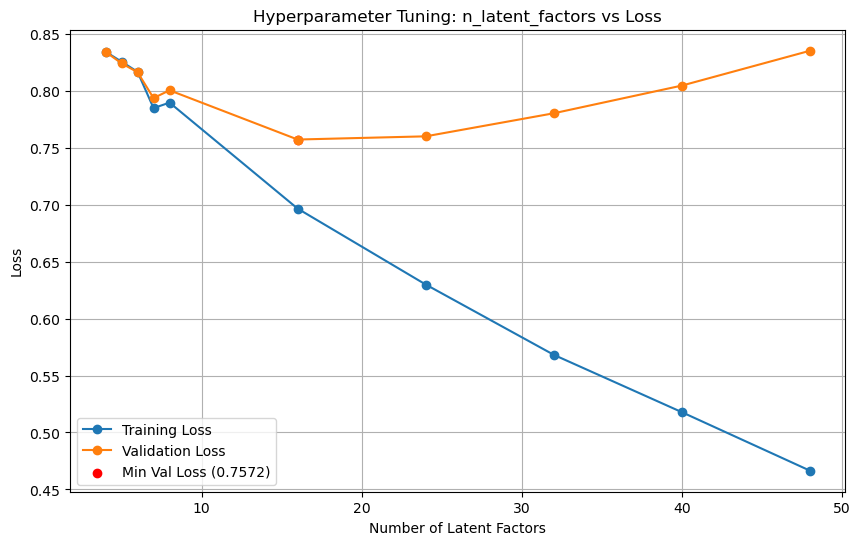

In [16]:
n_latent_factors_list = [result['n_latent_factors'] for result in results_list]
train_loss_list = [result['train_loss'] for result in results_list]
val_loss_list = [result['val_loss'] for result in results_list]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(n_latent_factors_list, train_loss_list, marker='o', label='Training Loss')
plt.plot(n_latent_factors_list, val_loss_list, marker='o', label='Validation Loss')

# Highlight the point with the minimum validation loss
min_val_loss_index = val_loss_list.index(min(val_loss_list))
min_val_loss_n_latent_factors = n_latent_factors_list[min_val_loss_index]
min_val_loss = min(val_loss_list)
plt.scatter(min_val_loss_n_latent_factors, min_val_loss, color='red', label=f'Min Val Loss ({min_val_loss:.4f})')

# Add labels and title
plt.xlabel('Number of Latent Factors')
plt.ylabel('Loss')
plt.title('Hyperparameter Tuning: n_latent_factors vs Loss')
plt.legend()
plt.grid(True)
plt.show()

In analyzing the provided figure, I observe a consistent reduction in the loss function within the validation set as the number of latent factors increases. However, a noteworthy trend emerges as the validation loss starts to rise beyond 16 latent factors, suggesting a point of diminishing returns and potential overfitting. To address this, I have decided to set the number of latent factors to 16.

# Matrix Factorization

In [21]:
n_movies=len(ratingsDf['movieId'].unique())
n_users=len(ratingsDf['userId'].unique())


# tuning hyperparameters

n_latent_factors = 16

In [22]:
user_input = Input(shape=(1,),name='user_input',dtype='int64')
user_embedding = Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)
movie_input = Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding = Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
sim = dot([user_vec,movie_vec],name='similarity_dot_product',axes=1)
model = keras.models.Model([user_input, movie_input],sim)

In [23]:
tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
train.shape
batch_size = 128
epochs = 50

In [24]:
model.compile(optimizer='adam', loss='mean_squared_error')
History = model.fit([train.userId,train.movieId],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.userId,valid.movieId],valid.rating),
                              verbose = 1)

Epoch 1/50
6257/6257 [==============================] - 5s 731us/step - loss: 4.6226 - val_loss: 0.9948
Epoch 2/50
6257/6257 [==============================] - 4s 706us/step - loss: 0.9008 - val_loss: 0.8619
Epoch 3/50
6257/6257 [==============================] - 5s 741us/step - loss: 0.8526 - val_loss: 0.8429
Epoch 4/50
6257/6257 [==============================] - 4s 709us/step - loss: 0.8257 - val_loss: 0.8167
Epoch 5/50
6257/6257 [==============================] - 4s 717us/step - loss: 0.7943 - val_loss: 0.7976
Epoch 6/50
6257/6257 [==============================] - 5s 732us/step - loss: 0.7696 - val_loss: 0.7843
Epoch 7/50
6257/6257 [==============================] - 4s 705us/step - loss: 0.7492 - val_loss: 0.7756
Epoch 8/50
6257/6257 [==============================] - 4s 705us/step - loss: 0.7294 - val_loss: 0.7684
Epoch 9/50
6257/6257 [==============================] - 4s 693us/step - loss: 0.7108 - val_loss: 0.7614
Epoch 10/50
6257/6257 [==============================] - 5s 757u

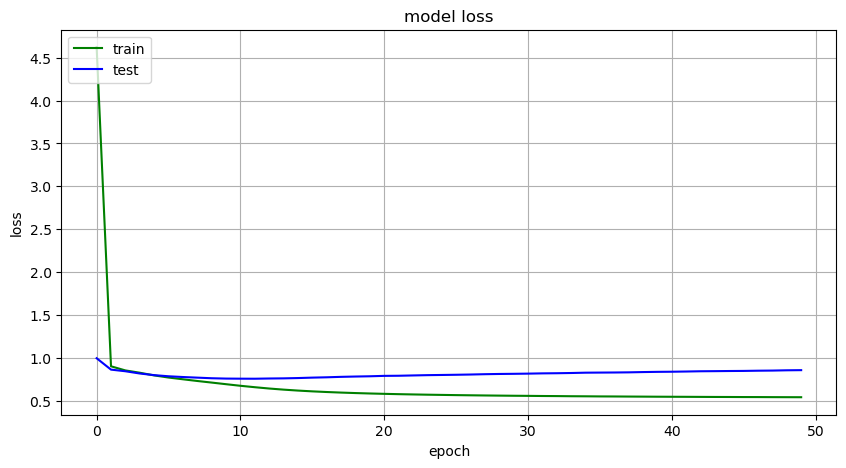

In [25]:
rcParams['figure.figsize'] = 10, 5

plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In the figure above, it is clear that the loss function for both the train and test datasets significantly decreases after several iterations. This highlights that the model is performing well in both training and testing situations and effectively addressing the overfitting issue.